<a href="https://colab.research.google.com/github/nitinsaimajji/voice1/blob/main/weekly_code/Week_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=e020d20dbb17d9177df2b72f73f452402dd264b2fd29f839fa573a149442f5c9
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
!git clone https://github.com/nitinsaimajji/voice1.git

Cloning into 'voice1'...
remote: Enumerating objects: 955, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 955 (delta 139), reused 197 (delta 91), pack-reused 672
Receiving objects: 100% (955/955), 168.24 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Updating files: 100% (1223/1223), done.


In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **A1**

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time
import IPython.display as ipd
import librosa
import librosa.display

In [ ]:
df = pd.read_csv('/content/voice1/wav_check.csv')
df[df['gender']=='male'].count()

filename    100
gender      100
dtype: int64

In [ ]:
TRAIN_PATH = '/content/voice/cv-valid-train/'
!pip install wavefile
!pip install helpers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wavefile: filename=wavefile-1.5-py3-none-any.whl size=11571 sha256=e63cb3121feb19f4b04c5b02075ac9e748c01081c75f44a1cf834d5a8b1e755c
  Stored in directory: /root/.cache/pip/wheels/4b/36/ae/e7914563b34aa35ba8f7b6274b686eff252256adf1583f8bfc
Successfully built wavefile
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
max_pad_len = 174

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

    return mfccs


In [ ]:

import os

fulldatasetpath = '/content/voice1/dataset1'

df = pd.read_csv('/content/voice1/wav_check.csv')


features = []


for index, row in df.iterrows():

    file_name = os.path.join(os.path.abspath(fulldatasetpath)+'/',str(row["filename"]))

    class_label = row["gender"]
    data = extract_features(file_name)

    features.append([data, class_label])


featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  200  files


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

## CNN ARCHITECTURE


#### ADAM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2


In [ ]:

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(lr=0.001))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 6.8250 - accuracy: 0.4938
Epoch 1: val_loss improved from inf to 1.87178, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 1s/step - loss: 6.8250 - accuracy: 0.4938 - val_loss: 1.8718 - val_accuracy: 0.4750
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 4.5796 - accuracy: 0.5000
Epoch 2: val_loss improved from 1.87178 to 1.68286, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 750ms/step - loss: 4.5796 - accuracy: 0.5000 - val_loss: 1.6829 - val_accuracy: 0.4750
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 4.5703 - accuracy: 0.5188
Epoch 3: val_loss improved from 1.68286 to 1.21565, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 965ms/step - loss: 4.5703 - accuracy: 0.5188 - val_loss: 1.2156 - val_accuracy: 0.4500
Epoch 4/72
1/1 [=

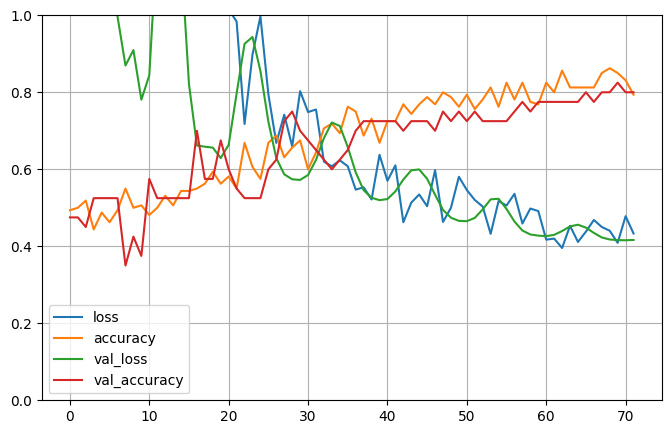

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [ ]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  88.12500238418579 %
Testing Accuracy:  80.0000011920929 %


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 0.4164 - accuracy: 0.8000 - 42ms/epoch - 21ms/step
Test loss: 0.416, Test accuracy: 0.800


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 9ms/step
Precision Score:  0.8020460358056265
Recall:  0.8
F1 Score:  0.798989898989899


In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1))
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [ ]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [ ]:
filename = '/content/output.wav'
print_prediction(filename)

1/1 [==============================] - 0s 30ms/step
The predicted class is: female 

female 		 :  84.27153825759887695312500000000000 %
male 		 :  15.72845727205276489257812500000000 %


In [ ]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195770.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [ ]:
filename = '/content/output.wav'
print_prediction(filename)

1/1 [==============================] - 0s 21ms/step
The predicted class is: male 

female 		 :  2.71555855870246887207031250000000 %
male 		 :  97.28444218635559082031250000000000 %


## **SGD**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from sklearn import metrics
from keras.optimizers import SGD
from keras.optimizers import RMSprop


num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2


# Dropout

In [ ]:

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=SGD(lr=0.01))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 9, 42, 32)        

In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 1.8170 - accuracy: 0.5500
Epoch 1: val_loss improved from inf to 38.63960, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 2s 2s/step - loss: 1.8170 - accuracy: 0.5500 - val_loss: 38.6396 - val_accuracy: 0.4750
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 58.4899 - accuracy: 0.5063
Epoch 2: val_loss improved from 38.63960 to 0.73043, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 2s 2s/step - loss: 58.4899 - accuracy: 0.5063 - val_loss: 0.7304 - val_accuracy: 0.4500
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 0.7990 - accuracy: 0.4375
Epoch 3: val_loss improved from 0.73043 to 0.70192, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 930ms/step - loss: 0.7990 - accuracy: 0.4375 - val_loss: 0.7019 - val_accuracy: 0.5000
Epoch 4/72
1/1 

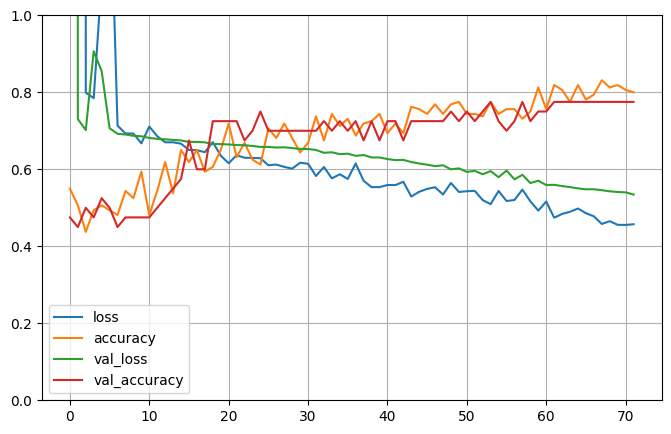

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [ ]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  83.74999761581421 %
Testing Accuracy:  77.49999761581421 %


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 0.5344 - accuracy: 0.7750 - 75ms/epoch - 37ms/step
Test loss: 0.534, Test accuracy: 0.775


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 17ms/step
Precision Score:  0.77625
Recall:  0.775
F1 Score:  0.775140712945591


In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1))
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [ ]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [ ]:
filename = '/content/output.wav'
print_prediction(filename)

1/1 [==============================] - 0s 37ms/step
The predicted class is: female 

female 		 :  60.60996651649475097656250000000000 %
male 		 :  39.39003050327301025390625000000000 %


## **RMSProp optimizer**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from sklearn import metrics
from keras.optimizers import SGD
from keras.optimizers import RMSprop


num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2


In [ ]:

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr=0.001))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 9, 42, 32)        

In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 12.7108 - accuracy: 0.5063
Epoch 1: val_loss improved from inf to 18.85670, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 3s 3s/step - loss: 12.7108 - accuracy: 0.5063 - val_loss: 18.8567 - val_accuracy: 0.5250
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 36.1496 - accuracy: 0.4938
Epoch 2: val_loss improved from 18.85670 to 0.91788, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 1s/step - loss: 36.1496 - accuracy: 0.4938 - val_loss: 0.9179 - val_accuracy: 0.5750
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 3.6375 - accuracy: 0.4750
Epoch 3: val_loss did not improve from 0.91788
1/1 [==============================] - 1s 918ms/step - loss: 3.6375 - accuracy: 0.4750 - val_loss: 7.9411 - val_accuracy: 0.4750
Epoch 4/72
1/1 [==============================] - ETA: 0s - loss: 10.6932 -

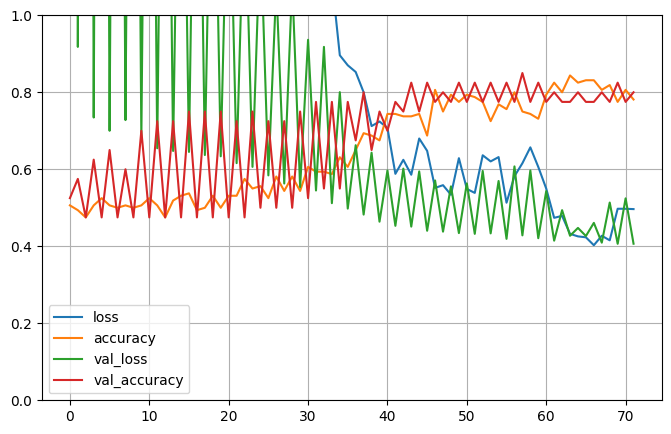

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [ ]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  86.2500011920929 %
Testing Accuracy:  80.0000011920929 %


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 0.4066 - accuracy: 0.8000 - 79ms/epoch - 40ms/step
Test loss: 0.407, Test accuracy: 0.800


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 17ms/step
Precision Score:  0.8106666666666668
Recall:  0.8
F1 Score:  0.7969309462915601


In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1))
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [ ]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [ ]:
filename = '/content/output.wav'
print_prediction(filename)

1/1 [==============================] - 0s 38ms/step
The predicted class is: female 

female 		 :  72.72157073020935058593750000000000 %
male 		 :  27.27842926979064941406250000000000 %


## **Adagrad Optimizer**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from sklearn import metrics
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad


num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2


In [ ]:

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adagrad(lr=0.01))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adagrad.py:84: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Display model architecture summary
model.summary()

# Calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 9, 42, 32)        

In [ ]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 15.3151 - accuracy: 0.5063
Epoch 1: val_loss improved from inf to 53.12366, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 2s 2s/step - loss: 15.3151 - accuracy: 0.5063 - val_loss: 53.1237 - val_accuracy: 0.5250
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 95.9145 - accuracy: 0.4938
Epoch 2: val_loss improved from 53.12366 to 6.41293, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 978ms/step - loss: 95.9145 - accuracy: 0.4938 - val_loss: 6.4129 - val_accuracy: 0.5250
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 13.6635 - accuracy: 0.4938
Epoch 3: val_loss improved from 6.41293 to 1.05455, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 2s 2s/step - loss: 13.6635 - accuracy: 0.4938 - val_loss: 1.0545 - val_accuracy: 0.5250
Epoch 4/72


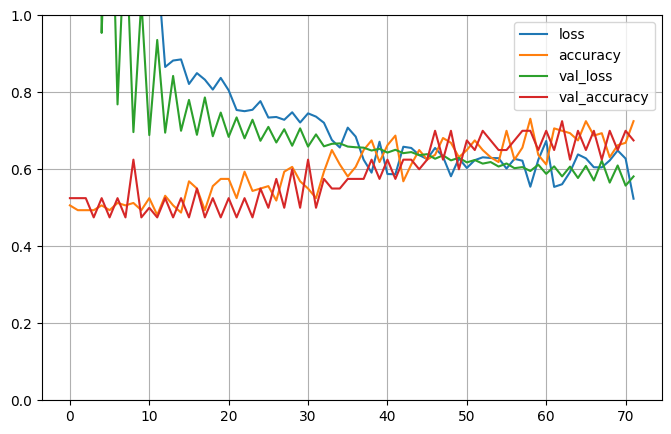

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [ ]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  75.0 %
Testing Accuracy:  67.5000011920929 %


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

2/2 - 0s - loss: 0.5814 - accuracy: 0.6750 - 75ms/epoch - 38ms/step
Test loss: 0.581, Test accuracy: 0.675


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

# Predict class labels on test set
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Print precision score
print("Precision Score: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

2/2 [==============================] - 0s 22ms/step
Precision Score:  0.7575000000000001
Recall:  0.675
F1 Score:  0.653818301514154


In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name)
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1))
    print("The predicted class is:", predicted_class[0], '\n')

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])):
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [ ]:
from pydub import AudioSegment

# set the file paths
input_file = "/content/sample-195283.mp3"
output_file = "/content/output.wav"

audio = AudioSegment.from_file(input_file, format="mp3")

audio.export(output_file, format="wav")

<_io.BufferedRandom name='/content/output.wav'>

In [ ]:
filename = '/content/output.wav'
print_prediction(filename)

1/1 [==============================] - 0s 36ms/step
The predicted class is: female 

female 		 :  67.97759532928466796875000000000000 %
male 		 :  32.02240467071533203125000000000000 %
